# Clustering cities for similar livability

## 1. Business problem

It is just about time in your life that someday you may want to move to another city. Could be a new job, could be relocation closer to your family, or could be that you want to try life in a different country. If that day comes, the most nature question you will have is “how is the new city different/similar from my current place”. In this project, I collect 6 democratic information from popular cities in the world, categories their differences, and put similar cities in groups.

The information I collect contributes to the so-called liveability index from [this Business Insider article](https://www.businessinsider.com/most-livable-cities-in-the-world-2018-8), including:
  - crime rate
  - education
  - culture
  - nature
  - health
  - infrastructure.
  
They help you depict most aspect of a city to be consider for living potential.

What you can get from the result? If you have to relocate, you can tell if the new city is similar to your place. If you aim for new experience, you can use the cluster to find cities that fit your purpose. Given this, you can have reasonable expectation and plans prior to moving.

## 2. Data

The clustering will be carried out on basic components of selected cities from all over the world. These cities can be chosen based on their size (eg. area, population or economy). Spatial area does not necessary reflect city popularity. Similar reason is applied for population. The economic strength is the most suitable indicator for our purpose. A well-developed city can be large (eg, Vancouver) or small (London), with high population (eg, Beijing) or low (Brussels). I get a list of such cities in [this wiki page](http://en.wikipedia.org/wiki/Globalization_and_World_Cities_Research_Network). With these, we need to acquire information mentioned above.

### 2.1. Crime rate

For crime rate, I use the data provided at [Numbeo website](https://www.numbeo.com/). The database is city-indexed and can be requested directly from city name.

### 2.2. Education, culture, nature, health, and infrastructure

For the other 5 criteria, I use the Foursquare database to find venues in each category. To request this, I first need each city's coordinate. The latitude and longitude can be requested similar to the crime rate (directly from city name) from [Geodatos website](http://www.geodatos.net/en/coordinates/).

For each city represented by a pair of latitude/longitude, I make an explore query by foursquare api, selecting the most popular 100 venues in an area with radius of 5 km. The returned venues’ categories will be put into 5 groups. Each group contains specific non-overlap foursquare categories summarized on [Foursquare development page](https://developer.foursquare.com/docs/resources/categories).

Ideally, after acquiring and cleaning data, what I have is a table with the following 9 columns: city name, latitude, longitude, crime index, counts of venues in 5 criteria groups. I will then run the unsupervised clustering on this data. In the result, if an user is interested in looking for places that are similar to his/her interested city, the cities that have the same cluster will be suggested.

## 3. Methodology

As described above, my project starts with getting the list of city from a Wikipedia page (3.1). Exploratory analysis consists of removing nan and summarizing cities in each country.

I then get the crime rate for each of these city from a third party website (3.2). Because of the differece in city naming convention, some entries need to be edited before acquiring the data. Moreover, some cities have no data. Exploratory analysis consists of removing nan and summarizing cities with highest and lowest crime rate.

The next step is to obtain geocoordinates of these cities from another third party website (3.3). Again, I need to edit some city names to match its database before crawling.

Before acquiring Foursquare venues, I need to build a classification of their categories based on the 5 criteria (3.4). This step involves getting all possible categories from Foursquare first, and then grouping them. How to build the 5 groups is described in more detail later.

The last data acquisition stage is getting popular venues in each city (3.5). This is straighforwardly done by calling the personal api.

After obtaining necessary data, for each city, I group all venues into groups and count how many places each group has (3.6). This step helps to find the most typical living criteria of the cities. Then this data is fed into an unsupervised clustering (3.7). This process finds cities that have similar living indexes. This result (4) will be analyzed later (5) to see the differences between group.

Finally, I provide an example of application to find and visualize similar cities from a specific city defined by the user (6).

In [1]:
from bs4 import BeautifulSoup
import requests as requests
import pandas as pd
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans

import folium
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

from sklearn import preprocessing

### 3.1. Get list of cities

In [2]:
url = "http://en.wikipedia.org/wiki/Globalization_and_World_Cities_Research_Network"
r = requests.get(url)
soup = BeautifulSoup(r.text,'html.parser')
t = soup.find_all('li')   # extract header content
cn = pd.DataFrame(columns=["city","nation"])
# Extracting data
for i in range(len(t)):
    u = t[i].find_all('a')
    if len(u)==2:
        cn = cn.append({'city': u[1].get('title'), 'nation': u[0].get('title')}, ignore_index=True )

#### Now check Nan values

In [3]:
print(len(cn))
cn.isna().sum()

367


city      2
nation    2
dtype: int64

The dataframe has 367 cities, 2 of which are nan that need to be removed:

In [4]:
cn.dropna(inplace = True)
print(len(cn))

365


The data now contains 365 cities.

Next I keep only the city name, remove the 'City' part in the returned dataset.

In [5]:
b=cn.city.str.split(",")
cn.city=b.str[0]
cn.sort_values("city", inplace = True)
cn.reset_index(drop=True, inplace = True)
cn.head()

,city,nation
0,Aarhus,Denmark
1,Aberdeen,United Kingdom
2,Abidjan,Ivory Coast
3,Abu Dhabi,United Arab Emirates
4,Abuja,Nigeria


#### Now count how many city in a country (Figure 1)

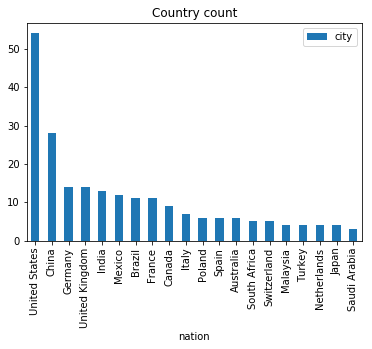

In [6]:
cn_nation = cn.groupby("nation").count()
cn_nation_sort = cn_nation.sort_values("city", ascending=False).head(20)
cn_nation_sort.plot.bar(title='Country count')

It's clear that the US has most many cities in the data, mostly because the criteria for choosing cities is ones that have impactful economic strength. The next is, not surprisingly, China. Then, most of G8 countries are in the list.

##### Please note that this figure will be referenced later in the Discussion.

### 3.2. Get Crime data

First, edit city names to match online database

In [7]:
# This cell is to fix some cities to match the online data

cn.loc[cn['city'] == "Córdoba", 'city'] = "Cordoba"

cn.loc[cn['city'] == "São Paulo", 'city'] = "Sao Paulo"
cn.loc[cn['city'] == "Zürich", 'city'] = "Zurich"
cn.loc[cn['city'] == "Bogotá", 'city'] = "Bogota"
cn.loc[cn['city'] == "Düsseldorf", 'city'] = "Dusseldorf"
cn.loc[cn['city'] == "San José", 'city'] = "San-Jose-Costa-Rica"

cn.loc[cn['city'] == "Asunción", 'city'] = "Asuncion"
cn.loc[cn['city'] == "Brasília", 'city'] = "Brasilia"
cn.loc[cn['city'] == "Chișinău", 'city'] = "Chisinau"
cn.loc[cn['city'] == "Ciudad Juárez", 'city'] = "Ciudad-Juarez"
cn.loc[cn['city'] == "Goiânia", 'city'] = "Goiania"
cn.loc[cn['city'] == "Kraków", 'city'] = "Krakow-Cracow"
cn.loc[cn['city'] == "Querétaro", 'city'] = "Queretaro"
cn.loc[cn['city'] == "Liège", 'city'] = "Liege"
cn.loc[cn['city'] == "Łódź", 'city'] = "Lodz"
cn.loc[cn['city'] == "Málaga", 'city'] = "Malaga"
cn.loc[cn['city'] == "Malmö", 'city'] = "Malmo"
cn.loc[cn['city'] == "Sanaʽa", 'city'] = "Sanaa-Yemen"
cn.loc[cn['city'] == "León, Guanajuato", 'city'] = "Leon"
cn.loc[cn['city'] == "León", 'city'] = "Leon"

cn.loc[cn['city'] == "Lomé", 'city'] = "Lome"
cn.loc[cn['city'] == "Medellín", 'city'] = "Medellin"
cn.loc[cn['city'] == "Mérida", 'city'] = "Merida"

cn.loc[cn['city'] == "Poznań", 'city'] = "Poznan"
cn.loc[cn['city'] == "Reykjavík", 'city'] = "Reykjavik"
cn.loc[cn['city'] == "Valparaíso", 'city'] = "Valparaiso"
cn.loc[cn['city'] == "Wrocław", 'city'] = "Wroclaw"
cn.loc[cn['city'] == "İzmir", 'city'] = "Izmir"

# after separating comma
cn.loc[cn['city'] == "Dammam", 'city'] = "Ad-Dammam"
cn.loc[cn['city'] == "Dar es Salaam", 'city'] = "Dar Es Salaam"


cn.loc[cn['city'] == "Jeddah", 'city'] = "Jeddah-Jiddah"
cn.loc[cn['city'] == "New Delhi", 'city'] = "Delhi"
cn.loc[cn['city'] == "Ürümqi", 'city'] = "Urumqi"
cn.loc[cn['city'] == "Kunming", 'city'] = "Kunming-Yunnan"
cn.loc[cn['city'] == "Macau", 'city'] = "Macao"
cn.loc[cn['city'] == "Seville", 'city'] = "Sevilla"
cn.loc[cn['city'] == "St. Louis", 'city'] = "Saint Louis"
cn.loc[cn['city'] == "Tel Aviv", 'city'] = "Tel-Aviv-Yafo"


cn.loc[cn['city'] == "Newcastle upon Tyne", 'city'] = "Newcastle Upon Tyne"
cn.loc[cn['city'] == "Port of Spain", 'city'] = "Port Of Spain"
cn.loc[cn['city'] == "Rio de Janeiro", 'city'] = "Rio De Janeiro"
cn.loc[cn['city'] == "Santa Cruz de la Sierra", 'city'] = "Santa Cruz"

# Fix duplicated cities
cn.loc[(cn.city=="Valencia") & (cn.nation=="Venezuela"), 'city'] = "Valencia-Venezuela"
cn.loc[(cn.city=="Birmingham") & (cn.nation=="United States"), 'city'] = "Birmingham-AL"

Scrape data

In [8]:
cn1 = pd.DataFrame(columns=["city", "safe", "nation"])
for i in range(len(cn["city"])):        # All cities
    a0= cn["city"][i]
    a1= cn["nation"][i] 
    a= a0.replace(" City","")
    a= a.replace(" ","-")
    page = pd.read_html('https://www.numbeo.com/crime/in/'+a)  # Scrape web page
    if len(page)==2:
        link1='https://www.numbeo.com/crime/in/'+a+'-'+str(pd.DataFrame(cn.loc[cn.city==a0]["nation"]).iloc[0]["nation"]).replace(" ","-")
        page = pd.read_html(link1)  # Scrape web page
        if len(page)<=4:   # this indicates no result
            link2='https://www.numbeo.com/crime/in/'+a+'-'+'City'
            page = pd.read_html(link2)  # Scrape web page
            if len(page)<=4:
                safeIndex = -2
                print(a, '--- NOT FOUND ---')
                cn1 = cn1.append({'city': a0 ,'nation': a1 , 'safe' : safeIndex},ignore_index=True )  
            else:
                b = str(page)
                b.find("Safety Index:")   # find start point
                b.find(",",a.find("Safety Index")) # find end point
                safeIndex = b[b.find("Safety Index:")+13:b.find(",",b.find("Safety Index"))].strip()
                cn1 = cn1.append({'city': a0 , 'nation': a1 ,'safe' : safeIndex},ignore_index=True )
        else:
            b = str(page)
            b.find("Safety Index:")   # find start point
            b.find(",",a.find("Safety Index")) # find end point
            safeIndex = b[b.find("Safety Index:")+13:b.find(",",b.find("Safety Index"))].strip()
            cn1 = cn1.append({'city': a0 ,'nation': a1 , 'safe' : safeIndex},ignore_index=True )
    else:
        b = str(page)
        b.find("Safety Index:")   # find start point
        b.find(",",a.find("Safety Index")) # find end point
        safeIndex = b[b.find("Safety Index:")+13:b.find(",",b.find("Safety Index"))].strip()
        cn1 = cn1.append({'city': a0 , 'nation': a1 ,'safe' : safeIndex},ignore_index=True )
print("----- DONE -----")

Aarhus --- NOT FOUND ---
Aligarh --- NOT FOUND ---
Labuan --- NOT FOUND ---
Loughborough-Lightning-(women's-cricket) --- NOT FOUND ---
Loughborough-Lightning-(women's-rugby-union) --- NOT FOUND ---
Taiyuan --- NOT FOUND ---
Urumqi --- NOT FOUND ---
----- DONE -----


#### Remove cities with no data

In [9]:
print(len(cn1[cn1.safe==-2]))
cn1.describe()

7


,city,safe,nation
count,365,365,365
unique,365,350,132
top,Houston,-2,United States
freq,1,7,54


There are 7 of them that need to be removed:

In [10]:
idex  = cn1[cn1.safe == -2].index
cn2 = cn1.drop(idex)
cn2 = cn2.reset_index(drop=True)
cn2["safe"] = pd.to_numeric(cn2["safe"])
cn2.describe()

,safe
count,358.000000
mean,55.840503
std,16.836823
min,1.960000
25%,44.395000
50%,56.940000
75%,69.765000
max,88.970000


#### Check nan values

In [11]:
cn2.safe.isna().sum()

0

The data after this stage has 358 cities.

#### Print the highest and lowest 10 cities

In [12]:
cn2_sort = cn2.sort_values("safe", ascending=False)
print(cn2_sort.head(10))

            city   safe                nation
129        Hefei  88.97                 China
91          Doha  88.52                 Qatar
2      Abu Dhabi  88.51  United Arab Emirates
219       Nagoya  87.82                 Japan
222      Nanjing  86.68                 China
316       Taipei  85.89                Taiwan
236       Ningbo  85.25                 China
267  Quebec City  84.95                Canada
143        Jinan  84.07                 China
312       Suzhou  83.38                 China


In [13]:
print(cn2_sort.tail(10))

                   city   safe        nation
275      Rio De Janeiro  22.68        Brazil
93               Douala  22.52      Cameroon
229               Natal  21.13        Brazil
290      San Pedro Sula  19.30      Honduras
144        Johannesburg  19.25  South Africa
97               Durban  19.08  South Africa
262            Pretoria  18.31  South Africa
336  Valencia-Venezuela  15.61     Venezuela
59              Caracas  15.03     Venezuela
213               Mosul   1.96          Iraq


We can see the most dangerous cities are found in China, and the safest cities are in South America/South Africa.

### 3.3. Get coordinates

First, edit city names to match online database

In [14]:
# This cell is to fix some cities to match online data
cn3 = cn2

cn3.loc[cn3['city'] == "Blantyre", 'city'] = "Blantyre-Malawi"
cn3.loc[cn3['city'] == "George Town", 'city'] = "George-Town-Cayman-Islands"
cn3.loc[cn3['city'] == "Hamilton", 'city'] = "Hamilton-Bermuda"
cn3.loc[cn3['city'] == "Valencia", 'city'] = "Valencia-Spain"
cn3.loc[cn3['city'] == "Bristol", 'city'] = "Bristol-UK"

Scrape data

In [15]:
d = pd.DataFrame(columns=["city", "lat", "lon"])
header = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
          "X-Requested-With": "XMLHttpRequest"}
for i in range(len(cn3["city"])):        # All cities
    a = cn3.city[i]
    link = 'http://www.geodatos.net/en/coordinates/search?q='+a
    r = requests.get(link, headers=header)
    if len(r.text) < 30000:
        dfs = pd.read_html(r.text)[0]
        d = d.append({'city': cn3.city[i],
                      'lat' : dfs.at[0,'Latitude'],
                      'lon': dfs.at[0,'Longitude']},
                     ignore_index=True )
    else:
        print(a,' ',link, '--- NOT FOUND')
print("----- DONE -----")

----- DONE -----


#### Check nan values

In [16]:
print(d.lat.isna().sum())
d.describe()

0


,city,lat,lon
count,358,358,358
unique,358,357,357
top,Houston,33.5185892,-86.8103567
freq,1,2,2


All cities are found, after this stage, our data still has 358 cities.

### 3.4. Get foursquare categories

In [17]:
r = requests.get('https://api.foursquare.com/v2/venues/categories?v=20170211&oauth_token=QEJ4AQPTMMNB413HGNZ5YDMJSHTOHZHMLZCAQCCLXIX41OMP&includeSupportedCC=true&fbclid=IwAR2PQaQ_ioYp6T6LmiyzdajNzqucIKx2two6t0vYAtXkn4E5ZgJFYsz5jFM')
cont = r.json()
a = cont["response"]["categories"]

Capture all subcategories

In [18]:
categ = []
df = pd.DataFrame(columns=["name","category"])
for index, row in json_normalize(a).iterrows():
    categ.append('cat.'+str(index)+'_'+row["name"])
    for i in range(len(a[index]["categories"])):
        t = a[index]["categories"][i]
        categ.append('cat.'+str(index)+'.'+str(i)+'_'+t["name"])
        if len(t["categories"])!=0:
            for j in range(len(t["categories"])):
                t1 = t["categories"]
                categ.append('cat.'+str(index)+'.'+str(i)+'.'+str(j)+'_'+str(t1[j]["name"]))
                if len(t1[j]["categories"])!=0:
                    for k in range(len(t1[j]["categories"])):
                        t2 = t1[j]["categories"]
                        categ.append('cat.'+str(index)+'.'+str(i)+'.'+str(j)+'.'+str(k)+'_'+str(t2[k]["name"]))
                        if len(t2[k]["categories"])!=0:
                            for l in range(len(t2[k]["categories"])):
                                t3=t2[k]["categories"]
                                categ.append('cat.'+str(index)+'.'+str(i)+'.'+str(j)+'.'+str(k)+'.'+str(l)+'_'+str(t3[l]["name"]))

categ = pd.DataFrame(categ, columns=['categories'])
categ

,categories
0,cat.0_Arts & Entertainment
1,cat.0.0_Amphitheater
2,cat.0.1_Aquarium
3,cat.0.2_Arcade
4,cat.0.3_Art Gallery
5,cat.0.4_Bowling Alley
6,cat.0.5_Casino
7,cat.0.6_Circus
8,cat.0.7_Comedy Club
9,cat.0.8_Concert Hall


##### Take all entry in these criteria:


- Health:
    * Medical Center (6.22)
    
- Culture:
    * Art and Entertainment (0)
    * Nightlife Spot (4)

- Environment:
    * Outdoors & Recreation (5) except Athletics & Sports (5.0) and States & Municipalities (5.52)

- Education: school and the like in Foursquare categories
    * College & University (1)
    * School (6.34)
    * Daycare (8.25)
    
- Infrastructure: focus on public transportation (bus stop, train station), commercial offices and the like in Foursquare categories
    * Travel & Transport (9) except Hotel (9.13)

In [19]:
catHealth = categ[categ["categories"].str.startswith('cat.6.22')]
catHealth = pd.DataFrame(catHealth.categories.str.split('_').str[1])

catEducation = categ[categ["categories"].str.startswith('cat.1') | categ["categories"].str.startswith('cat.6.34') | categ["categories"].str.startswith('cat.8.25')]
catEducation = pd.DataFrame(catEducation.categories.str.split('_').str[1])

catCulture = categ[categ["categories"].str.startswith('cat.0') | categ["categories"].str.startswith('cat.4')]
catCulture = pd.DataFrame(catCulture.categories.str.split('_').str[1])

catInfrastructure = categ[categ["categories"].str.startswith('cat.9')]
catInfrastructure = catInfrastructure[~catInfrastructure["categories"].str.startswith('cat.9.13')]
catInfrastructure = pd.DataFrame(catInfrastructure.categories.str.split('_').str[1])

catEnvironment = categ[categ["categories"].str.startswith('cat.5')]
catEnvironment = catEnvironment[~catEnvironment["categories"].str.startswith('cat.5.0')]
catEnvironment = catEnvironment[~catEnvironment["categories"].str.startswith('cat.5.52')]
catEnvironment = pd.DataFrame(catEnvironment.categories.str.split('_').str[1])

In [20]:
catHealth.head()

,categories
632,Medical Center
633,Acupuncturist
634,Alternative Healer
635,Chiropractor
636,Dentist's Office


#### Now create a dataframe with city, lat, long, safe index, and add 5 more empty columns for each criteria

In [21]:
e2 = pd.concat([d, cn2.safe, cn2.nation], axis=1)
e2["lat"] = pd.to_numeric(e2["lat"])   
e2["lon"] = pd.to_numeric(e2["lon"])  
e2 = e2.reindex(columns=[*e2.columns.tolist(), 'catCulture', 'catEducation', 'catHealth', 'catEnvironment', 'catInfrastructure'], fill_value=0)

In [22]:
e2.describe()

,lat,lon,safe,catCulture,catEducation,catHealth,catEnvironment,catInfrastructure
count,358.000000,358.000000,358.000000,358.0,358.0,358.0,358.0,358.0
mean,28.120047,3.577499,55.840503,0.0,0.0,0.0,0.0,0.0
std,24.224879,75.086607,16.836823,0.0,0.0,0.0,0.0,0.0
min,-43.532054,-157.858333,1.960000,0.0,0.0,0.0,0.0,0.0
25%,19.128721,-73.343785,44.395000,0.0,0.0,0.0,0.0,0.0
50%,35.206326,8.611910,56.940000,0.0,0.0,0.0,0.0,0.0
75%,44.942762,47.299753,69.765000,0.0,0.0,0.0,0.0,0.0
max,64.146582,174.776236,88.970000,0.0,0.0,0.0,0.0,0.0


After this stage, our data has 358 cities, and empty columns for the 5 criteria that will be filled later in the next stage.

### 3.5. Get Foursquare venues

I acquire the most 100 places in the rarius of 5 km in these cities. This covers an area of about 80 km2, or a medium size city.

In [23]:
CLIENT_ID = 'HRQEKGN0SL2TOMK2PKTGEP4ONM3ZM3ZWLPKOERVPYHNISX5M' # your Foursquare ID
CLIENT_SECRET = 'YJZ4KJ5H3CC4V1DW3Z2Y0L5UTQPKSTJRU1HSSVOE2VKLU3OY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Define the function for craping and writing data to the output 

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000, LIMIT=100):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['city', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

Scrape data

In [25]:
# Explore within radius of 5 km, for 100 places in each city
cityvenues = getNearbyVenues(names=e2['city'],
                                   latitudes=e2['lat'],
                                   longitudes=e2['lon'])
print('----- COMPLETED -----')

----- COMPLETED -----


### 3.6. Group returned venues into the 5 category criteria

In [26]:
for row in e2["city"]:
    t = cityvenues[cityvenues.city == row]
    e2.loc[e2.city==row, "catCulture"]=t.apply(lambda x: True if x["Venue Category"] in str(catCulture) else False, axis=1).sum()
    e2.loc[e2.city==row, "catEnvironment"]=t.apply(lambda x: True if x["Venue Category"] in str(catEnvironment) else False, axis=1).sum()
    e2.loc[e2.city==row, "catHealth"]=t.apply(lambda x: True if x["Venue Category"] in str(catHealth) else False, axis=1).sum()
    e2.loc[e2.city==row, "catEducation"]=t.apply(lambda x: True if x["Venue Category"] in str(catEducation) else False, axis=1).sum()
    e2.loc[e2.city==row, "catInfrastructure"]=t.apply(lambda x: True if x["Venue Category"] in str(catInfrastructure) else False, axis=1).sum()
print('----- COMPLETED -----')

----- COMPLETED -----


In [27]:
e2[["lat", "lon", "safe", "catCulture", "catEducation", "catHealth", "catEnvironment", "catInfrastructure"]] = e2[["lat", "lon", "safe", "catCulture", "catEducation", "catHealth", "catEnvironment", "catInfrastructure"]].apply(pd.to_numeric)

#### Check for nan

In [28]:
print(e2.lat.isna().sum())
e2.describe()

0


,lat,lon,safe,catCulture,catEducation,catHealth,catEnvironment,catInfrastructure
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,28.120047,3.577499,55.840503,24.357542,2.958101,0.030726,8.905028,5.047486
std,24.224879,75.086607,16.836823,10.390180,2.374215,0.188329,5.737188,3.259201
min,-43.532054,-157.858333,1.960000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.128721,-73.343785,44.395000,17.000000,1.000000,0.000000,4.000000,3.000000
50%,35.206326,8.611910,56.940000,26.000000,3.000000,0.000000,9.000000,5.000000
75%,44.942762,47.299753,69.765000,31.000000,4.000000,0.000000,12.000000,7.000000
max,64.146582,174.776236,88.970000,49.000000,13.000000,2.000000,28.000000,15.000000


The data summary shows very low `catHealth` index. This implies that Health index might not contribute to the classification. For demonstration purpsose, it is kept in this analysis, but one can remove `catHealth` to see if there is any difference. Initial examination suspects there is not.

### 3.7. k-means clustering

For this project, I choose unsupervised learning because it's one of the most effective way to get insights about the data without human bias (normally introduced by selecting training data).

I pick k-means clustering because it works for numerical data and the result is easy to interpret.

In this project, I select k=3 simply because of a natural thinking toward numeric number range: "low" - "mid" - "high". Of course one can have a better idea, but for a blind unbiased approach, this is a good starting point.

In terms of preconditioning, it should be noted that the output venue count is in percentage unit that matches the safety crime index. Therefore, normalization is not required because relative venues ratio in each city is reached with 100 samples.

In [29]:
kclusters = 3
f_clustering = e2.drop(['city','lat','lon', 'nation'], 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(f_clustering)

## 4. Results

In [30]:
g = e2
if len(g)==10:
    g.insert(0, 'Cluster Labels', kmeans.labels_)
else:
    g['Cluster Labels']= kmeans.labels_
    
g = g.dropna()
g["Cluster Labels"] = g["Cluster Labels"].astype(int)

In order to analyze this result, we need to compare the statistics of each group with the whole data.

#### Let's look at the statistics of the grouped data

In [31]:
g.describe()

,lat,lon,safe,catCulture,catEducation,catHealth,catEnvironment,catInfrastructure,Cluster Labels
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,28.120047,3.577499,55.840503,24.357542,2.958101,0.030726,8.905028,5.047486,1.019553
std,24.224879,75.086607,16.836823,10.390180,2.374215,0.188329,5.737188,3.259201,0.786552
min,-43.532054,-157.858333,1.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.128721,-73.343785,44.395000,17.000000,1.000000,0.000000,4.000000,3.000000,0.000000
50%,35.206326,8.611910,56.940000,26.000000,3.000000,0.000000,9.000000,5.000000,1.000000
75%,44.942762,47.299753,69.765000,31.000000,4.000000,0.000000,12.000000,7.000000,2.000000
max,64.146582,174.776236,88.970000,49.000000,13.000000,2.000000,28.000000,15.000000,2.000000


#### and now the statistics of each cluster:

In [32]:
g.groupby('Cluster Labels').mean()

,lat,lon,safe,catCulture,catEducation,catHealth,catEnvironment,catInfrastructure
Cluster Labels,,,,,,,,
0,11.163473,-26.307907,36.107850,18.177570,2.943925,0.065421,5.822430,3.644860
1,35.763806,-6.082107,56.007226,31.080292,3.510949,0.029197,11.540146,6.072993
2,34.849506,43.236310,74.161140,22.078947,2.307018,0.000000,8.631579,5.131579



Compare this table with the previous, we can see the difference between the three groups in terms of each criteria:

- Safety, three intervals are clearly distinct with mean values round the mean of the whole safety (55): group 1 is around this value, groups 0 and 2 have values of 36 and 74, smaller than the 25% quantile (44) and larger than 75% quantile (69).

- Culture, class 0 has high value of 31, equal the 75% quantile of this criteria. Classes 1 and 2 are similar and below average.

- Education, three classes are not siginificantly different.

- Health, in the description table, the variance is even larger than the mean. This indicate this criteria doesn't contribute into the clustering. Please note that my standard for health is counting the number of hospital and health department, not necessary the quality.

- Environment, class 1 has highest score, while classes 0 and 2 are lower distinctly.

- Infrastructure, classes 0 and 2 have similar values to the 25% and 50% quantiles, while class 1 is a bit lower than the 75% quantile.

With these observations, I have my interpretation as follow:
- Class 0 - developing cities: lowest crime rate and other living indexes except education (for development).
- Class 1 - working cities:  best for democratic indexes but medium crime rate - best for career and financial dynamic life (high crime rate is quite common for such cities).
- Class 2 - trade-off cities: average in living indicators but high crime index.

In [33]:
g["Cluster name"] = ""
g.loc[g['Cluster Labels']==0, ['Cluster name']] = 'Developing city'
g.loc[g['Cluster Labels']==1, ['Cluster name']] = 'Working city'
g.loc[g['Cluster Labels']==2, ['Cluster name']] = 'Trade-off city'

#### Visualization from the results

In [34]:
map_clusters = folium.Map(location=[0,0], zoom_start=2)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.brg(np.linspace(1, 0, len(ys)))
colorindex = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster, name in zip(g['lat'], g['lon'], g['city'], g['Cluster Labels'], g['Cluster name']):
    label = folium.Popup(str(poi) + '. ' + name, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=[],
        fill=True,
        fill_color=colorindex[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)       
map_clusters

## 5. Discussion

Now let's see if there is any country that has most cities fall into these classes:

In [35]:
g[g["Cluster Labels"]==0].groupby("nation").count().sort_values("city",ascending = False).head()

,city,lat,lon,safe,catCulture,catEducation,catHealth,catEnvironment,catInfrastructure,Cluster Labels,Cluster name
nation,,,,,,,,,,,
United States,19,19,19,19,19,19,19,19,19,19,19
Brazil,11,11,11,11,11,11,11,11,11,11,11
Mexico,8,8,8,8,8,8,8,8,8,8,8
South Africa,5,5,5,5,5,5,5,5,5,5,5
India,3,3,3,3,3,3,3,3,3,3,3


In [36]:
g[g["Cluster Labels"]==1].groupby("nation").count().sort_values("city",ascending = False).head()

,city,lat,lon,safe,catCulture,catEducation,catHealth,catEnvironment,catInfrastructure,Cluster Labels,Cluster name
nation,,,,,,,,,,,
United States,31,31,31,31,31,31,31,31,31,31,31
United Kingdom,14,14,14,14,14,14,14,14,14,14,14
France,10,10,10,10,10,10,10,10,10,10,10
Germany,9,9,9,9,9,9,9,9,9,9,9
Italy,6,6,6,6,6,6,6,6,6,6,6


In [37]:
g[g["Cluster Labels"]==2].groupby("nation").count().sort_values("city",ascending = False).head()

,city,lat,lon,safe,catCulture,catEducation,catHealth,catEnvironment,catInfrastructure,Cluster Labels,Cluster name
nation,,,,,,,,,,,
China,22,22,22,22,22,22,22,22,22,22,22
Canada,6,6,6,6,6,6,6,6,6,6,6
Germany,5,5,5,5,5,5,5,5,5,5,5
Poland,4,4,4,4,4,4,4,4,4,4,4
United States,4,4,4,4,4,4,4,4,4,4,4


No surprisingly, as the most developed country, the US mainly has developing or full work cities (classes 0 and 1, respectively). China with the reputation of pollution and closed politics has highest crime rate (found in 3.2) and ranks 1st in the trade-off cities (class 2). These findings can be easily spotted on the class map above: the bad cities (class 2 - red) in China, developing (class 0 - blue) and full working (class 1 - green) cities in the US.

Of course, a factor that these 2 countries make up most of the data (found in Figure 1) infers they can rank the first in any statistics. If we instead look at the distribution in each country for now, it is found that most UK cities are good working cities, followed by France and Germany. We can also find that most of the EU are good (except for Central Europian cities); South America and South Africa are best for development; Middle East and Japan are also trade-off cities between development and stability.

All these information can be used as a recommendation guideline for ones who are using the tool for making decision.

# 6. Application

Now one can try finding places similar to his

In [38]:
ctest = input("Your reference city: ")
if ctest.lower() in set(g.city.str.lower()):
    idex = g.index[g.city.str.lower() == ctest.lower()].tolist()
    clustervalue = g.iloc[idex]["Cluster Labels"].tolist()
else:
    print('Your city is not in the list. Try another.')

Your reference city: madrid


Find the difference between other cities in the same cluster

In [39]:
h = g[g["Cluster Labels"]==clustervalue[0]]
h.reset_index(drop=True,inplace=True)
i = h.drop(columns=['lat', 'lon','city','nation','Cluster name'])
# Normalization
normalized_i=(i-i.min())/(i.max()-i.min())
idex = h.index[h.city.str.lower() == ctest.lower()].tolist()
normalized_i_diff = pd.DataFrame()
for x in range(len(normalized_i)):
    normalized_i_diff=normalized_i_diff.append(normalized_i.iloc[x]-normalized_i.iloc[idex],ignore_index=True )
y = abs(normalized_i_diff).sum(axis=1)
h1 = pd.concat([h.city,h.lat,h.lon, y], axis=1)
h1.columns = ['city','lat','lon','diff']

### Show the most 5 similar cities

In [40]:
# Sort by difference
h1 = h1.sort_values('diff')
h1['stt'] = range(1, len(h1) + 1)
h1.reset_index(drop=True,inplace=True)
h1.head(6)

,city,lat,lon,diff,stt
0,Madrid,40.416775,-3.703790,0.000000,1
1,Helsinki,60.169856,24.938379,0.407502,2
2,Poznan,52.406374,16.925168,0.444031,3
3,Mannheim,49.487459,8.466040,0.495382,4
4,Bucharest,44.426767,26.102538,0.498187,5
5,Wroclaw,51.107885,17.038538,0.570776,6


### Plot a map show other similar cities in the world

#### Color is based on similarity, the darker the more similar

In [41]:
map_clusters = folium.Map(location=[0,0], zoom_start=2)
ncolor = len(h1)
x = np.arange(ncolor)
ys = [i + x + (i*x)**2 for i in range(ncolor)]
colors_array = cm.summer(np.linspace(0, 1, len(ys)))

rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lon, poi, stt in zip(h1['lat'], h1['lon'], h1['city'], h1['stt']):
    label = folium.Popup(str(poi) + '. Diff: ' + str(stt), parse_html=True)
    folium.CircleMarker([lat, lon], radius=3, popup=label, color=[], 
                        fill=True, fill_color=rainbow[stt-1], fill_opacity=1).add_to(map_clusters)
map_clusters

## 7. Conclusions

The project has grouped most popular cities in the world. The similarity between these groups are measured based on the 6 main living indexes, including crime, health, culture, nature, education, and infrastructure. Three main city groups are determined associating to living, working and resting conditions.

Closer examination into each group and their international relationship also reveals interesting findings between countries. Possible explanations are provided to support them. An applied example is shown to demonstrate how one can use the result to get meaningful information. I hope the users find this work and its results useful.